In [143]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob
import cv2
import seaborn as sns
import os 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras import applications
from keras import backend as K
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt

In [144]:

mura_Dir = "MURA-v1.1/"
train_imgs_path=pd.read_csv(mura_Dir+'train_image_paths.csv',names=["Train Dataset"])
train_labels=pd.read_csv(mura_Dir+'train_labeled_studies.csv',names=["Train Labeled Studies","label"])
test_imgs_path=pd.read_csv(mura_Dir+'valid_image_paths.csv',names=["Test Dataset"])
test_labels=pd.read_csv(mura_Dir+'valid_labeled_studies.csv',names=["Test Labeled Studies","label"])

In [145]:
train_imgs_path=train_imgs_path.sort_values(by=['Train Dataset'])
train_labels=train_labels.sort_values(by=['Train Labeled Studies'])
test_imgs_path=test_imgs_path.sort_values(by=['Test Dataset'])
test_labels=test_labels.sort_values(by=['Test Labeled Studies'])

In [146]:
test_labels['Body Part']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
test_labels['Study Type']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])
test_labels['p']=test_labels['Test Labeled Studies'].apply(lambda x: str(x.split('/')[3])[:20])


In [147]:
train_labels['Body Part']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study Type']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])
train_labels['p']=train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[3])[:20])


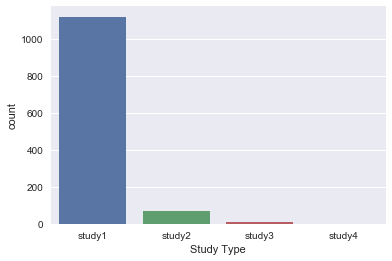

In [148]:
sns.countplot(data=test_labels,x='Study Type')

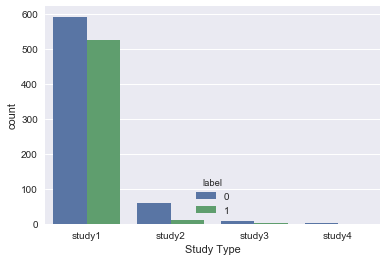

In [149]:
sns.countplot(data=test_labels,x='Study Type',hue='label')

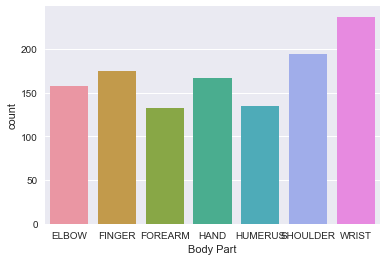

In [150]:
sns.countplot(data=test_labels,x='Body Part')

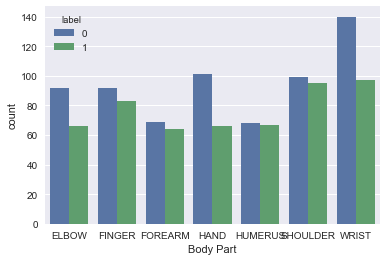

In [151]:
import seaborn as sns
sns.countplot(data=test_labels,x='Body Part',hue='label')

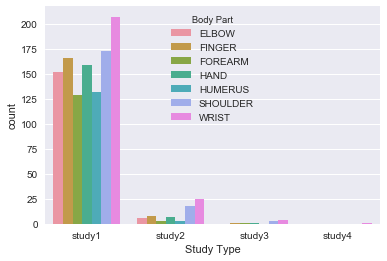

In [152]:
sns.countplot(data=test_labels,x='Study Type',hue='Body Part')

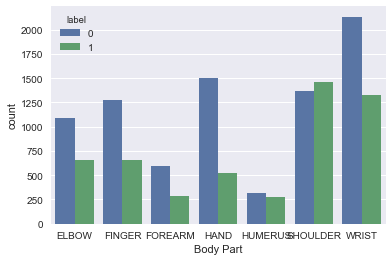

In [153]:
sns.countplot(data=train_labels,x='Body Part',hue='label')

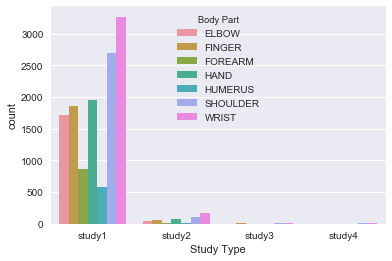

In [154]:
sns.countplot(data=train_labels,x='Study Type',hue='Body Part')

In [155]:
def fileImagesOfStudy(path):
    img_dir = path # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    i=0
    for f1 in files:
        i=i+1
        img = cv2.imread(f1)
        data.append(img)
           
    return data

In [156]:
import matplotlib.pyplot as plt


In [157]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.grid(False)

    plt.show()

In [158]:
def stretching_Data(files_,dim):
    stretch=[]
    for e in tqdm(range(0,len(files_))):
        f=files_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            stretch.append(cv2.resize(dd[n],dsize=dim))
               
    return stretch

In [159]:
def stretching_Labels(labels_):
    labels=[]
    for e in tqdm(range(0,len(labels_))):
        l=labels_.iloc[e]['label']
        f=labels_.iloc[e][0]
        dd=fileImagesOfStudy(f)
        for n in range(0,len(dd)):
            labels.append(l)
    return labels

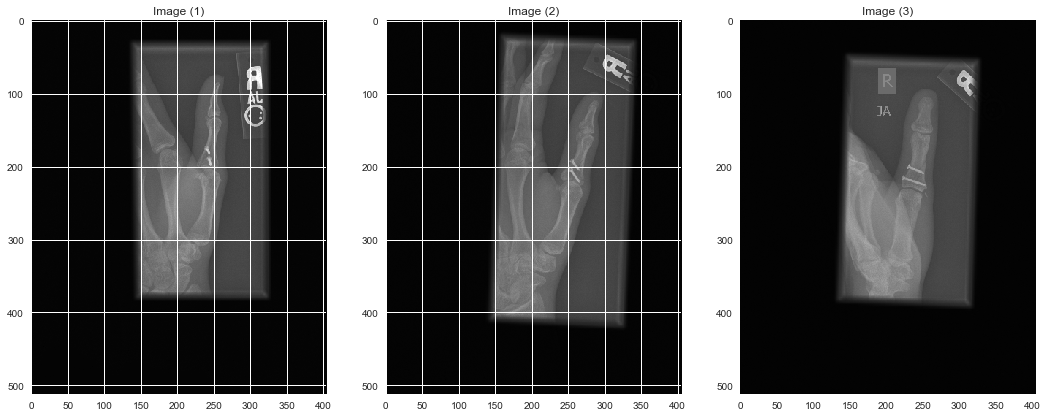

In [160]:
l=train_labels.iloc[2000]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

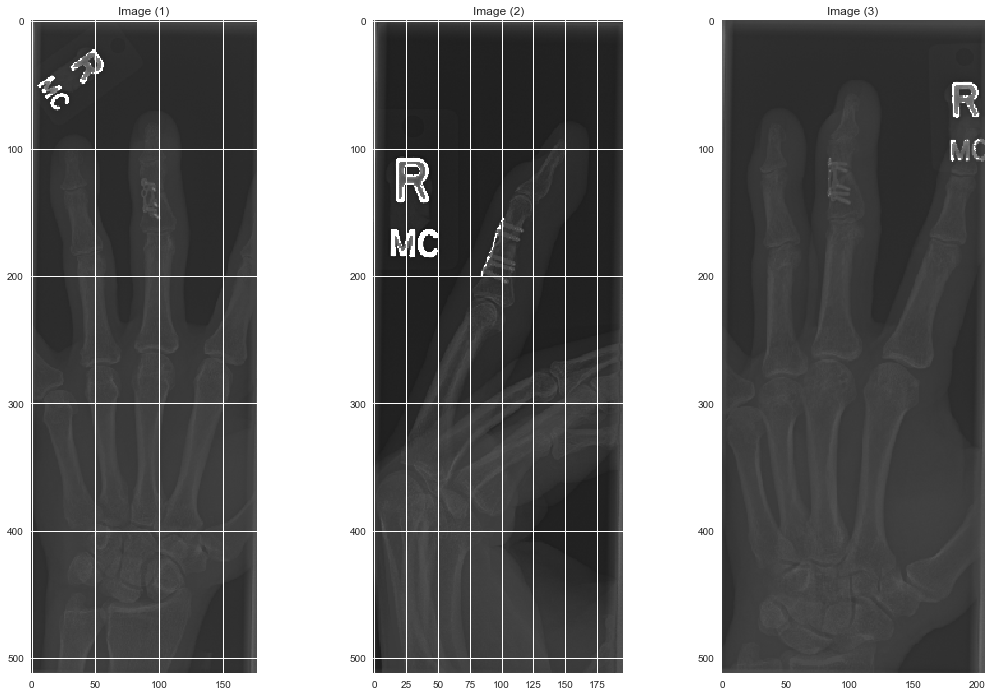

In [161]:
l=train_labels.iloc[2093]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

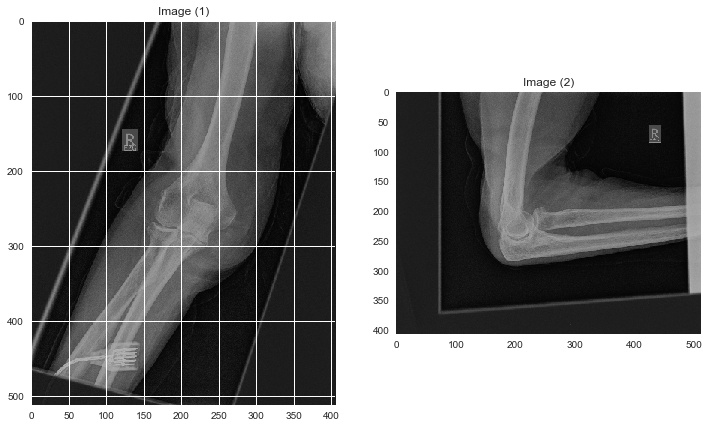

In [162]:
l=train_labels.iloc[3]['Train Labeled Studies']
images=fileImagesOfStudy(l)
show_images(images)

In [163]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
%matplotlib inline
plt.style.use("seaborn")


In [164]:
def prepareDataVGG(className):
    reszizing_Dim=(60,60)
    train_= train_labels[train_labels['Body Part'] ==className]
    test_ = test_labels[test_labels['Body Part'] ==className]
    data__Test=stretching_Data(test_,reszizing_Dim)
    labels_Test=stretching_Labels(test_)
    data__Train=stretching_Data(train_,reszizing_Dim)
    labels_Train=stretching_Labels(train_)
    data__Test=np.asarray(data__Test)
    labels_Test=np.asarray(labels_Test)
    data__Train=np.asarray(data__Train)
    labels_Train=np.asarray(labels_Train)

    return data__Train,labels_Train,data__Test,labels_Test

In [165]:
def prepareDataMobile(className):
    reszizing_Dim=(224,224)
    train_= train_labels[train_labels['Body Part'] ==className]
    test_ = test_labels[test_labels['Body Part'] ==className]
    data__Test=stretching_Data(test_,reszizing_Dim)
    labels_Test=stretching_Labels(test_)
    data__Train=stretching_Data(train_,reszizing_Dim)
    labels_Train=stretching_Labels(train_)
    data__Test=np.asarray(data__Test)
    labels_Test=np.asarray(labels_Test)
    data__Train=np.asarray(data__Train)
    labels_Train=np.asarray(labels_Train)

    return data__Train,labels_Train,data__Test,labels_Test

In [166]:
def vgg19Model(data__Train,labels_Train,data__Test,labels_Test):

    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=data__Train.shape[1:])
    vgg_model = Sequential()
    vgg_model.add(vgg19)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1, activation='sigmoid'))
    vgg_model.layers[0].trainable = False
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_vgg19 = vgg_model.fit(data__Train, labels_Train, epochs=5, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history_vgg19,vgg_model

In [167]:
def plotingModel(history_):

    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title("Train vs Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(False)

    plt.legend(['train', 'test'], loc='upper right')

In [168]:
def plotResults(data__Test,labels_Test,vgg_model):
    test_loss, test_acc = vgg_model.evaluate(data__Test, labels_Test, batch_size=100)
    print("Loss on test set: ", test_loss)
    print("Accuracy on test set: ", test_acc)
    test_logits = vgg_model.predict(data__Test, batch_size=10)
    cm  = confusion_matrix(labels_Test, np.round(test_logits))
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
    plt.xticks(range(2), ['Normal', 'Abnromal'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Abnormal'], fontsize=16)
    plt.show()
    true_negative, false_positive, false_negative, true_positive  = cm.ravel()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    print('Precison of MURA for Abnormal:{:.2f}'.format(precision))
    print('Recall of MURA for Abnormal:{:.2f}'.format(recall))
    num_test = 50
    predictions = vgg_model.predict(data__Test[:num_test,:,:,:])
    for i in range(num_test):
        if predictions[i] <test_acc:
            print("Predicted: Abnormal ",predictions[i])
        else:
            print("predicted: Normal",predictions[i])
        plt.imshow(data__Test[i])
        plt.grid(False)

        plt.show()
    return test_acc
   

In [169]:
def vgg19Model(data__Train,labels_Train,data__Test,labels_Test):

    vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=data__Train.shape[1:])
    vgg_model = Sequential()
    vgg_model.add(vgg19)
    vgg_model.add(Flatten())
    vgg_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    vgg_model.add(Dropout(0.5))
    vgg_model.add(Dense(1, activation='sigmoid'))
    vgg_model.layers[0].trainable = False
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_vgg19 = vgg_model.fit(data__Train, labels_Train, epochs=10, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history_vgg19,vgg_model

100%|██████████| 592/592 [00:09<00:00, 65.44it/s]


Train on 1272 samples, validate on 288 samples
Epoch 1/10
1272/1272 [==============================] - 325s 255ms/step - loss: 7.0442 - accuracy: 0.5385 - val_loss: 4.7239 - val_accuracy: 0.6146
Epoch 2/10
1272/1272 [==============================] - 347s 273ms/step - loss: 4.9425 - accuracy: 0.6108 - val_loss: 4.1022 - val_accuracy: 0.7014
Epoch 3/10
1272/1272 [==============================] - 327s 257ms/step - loss: 4.2901 - accuracy: 0.6053 - val_loss: 3.8202 - val_accuracy: 0.6597
Epoch 4/10
1272/1272 [==============================] - 321s 252ms/step - loss: 3.9057 - accuracy: 0.6124 - val_loss: 3.5527 - val_accuracy: 0.6806
Epoch 5/10
1272/1272 [==============================] - 330s 259ms/step - loss: 3.5088 - accuracy: 0.6439 - val_loss: 3.3102 - val_accuracy: 0.7049
Epoch 6/10
1272/1272 [==============================] - 323s 254ms/step - loss: 3.2898 - accuracy: 0.6525 - val_loss: 3.0953 - val_accuracy: 0.7188
Epoch 7/10
1272/1272 [==============================] - 321s 253m

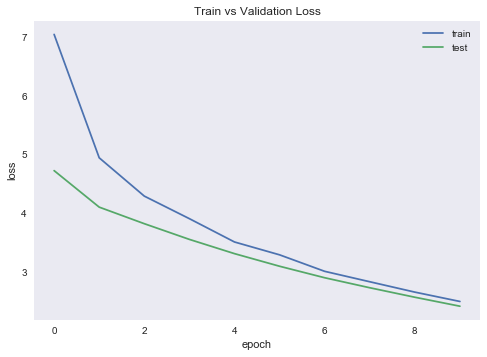

<Figure size 576x396 with 0 Axes>

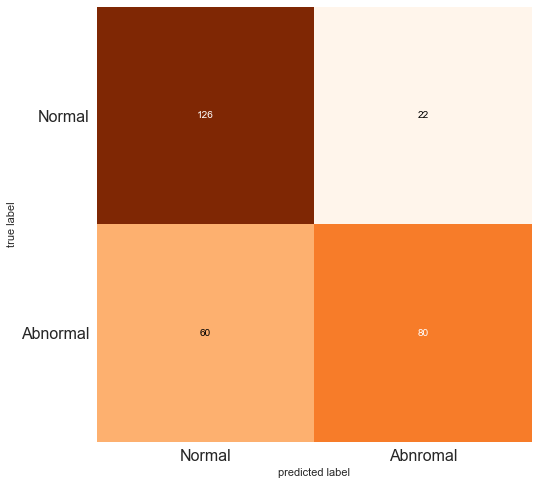

Precison of MURA for Abnormal:0.78
Recall of MURA for Abnormal:0.57
Predicted: Abnormal  [0.37778342]


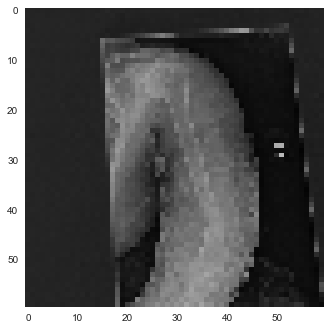

Predicted: Abnormal  [0.42500472]


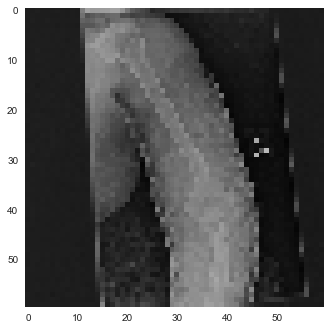

Predicted: Abnormal  [0.32685193]


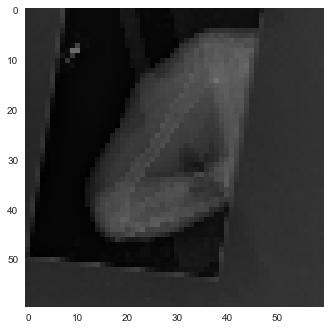

Predicted: Abnormal  [0.5508806]


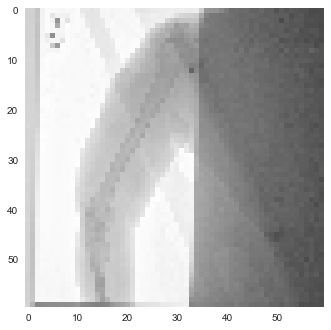

Predicted: Abnormal  [0.43059865]


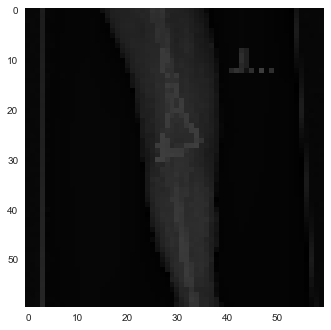

Predicted: Abnormal  [0.40074402]


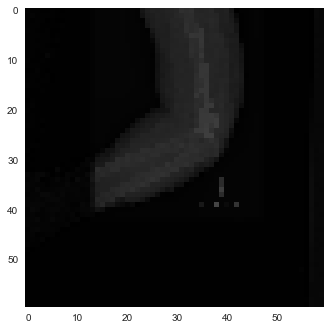

Predicted: Abnormal  [0.48384723]


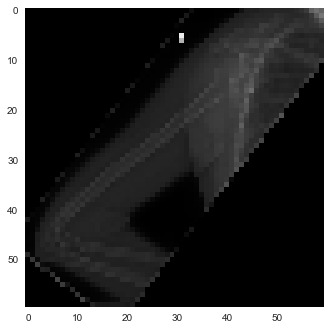

Predicted: Abnormal  [0.6462558]


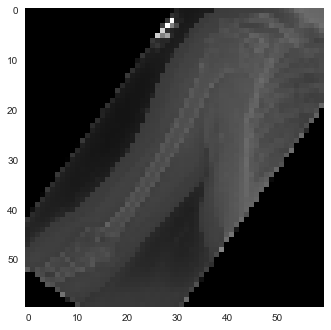

Predicted: Abnormal  [0.38313693]


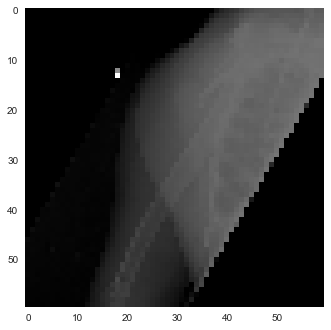

Predicted: Abnormal  [0.28966683]


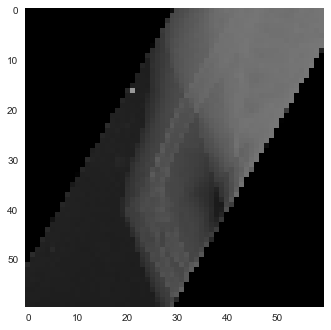

Predicted: Abnormal  [0.575463]


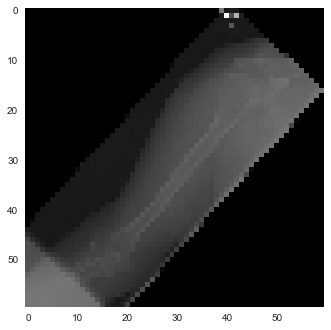

Predicted: Abnormal  [0.43253493]


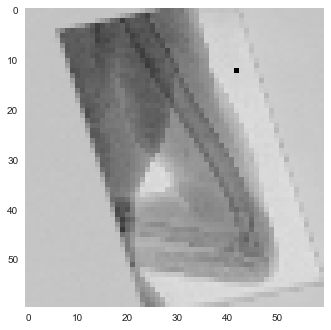

Predicted: Abnormal  [0.31289244]


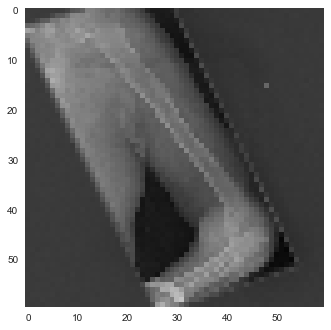

Predicted: Abnormal  [0.31698865]


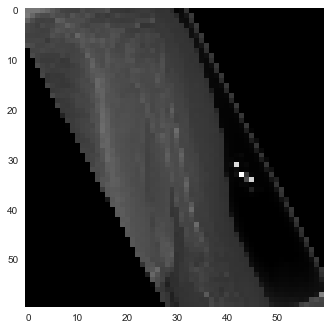

predicted: Normal [0.769834]


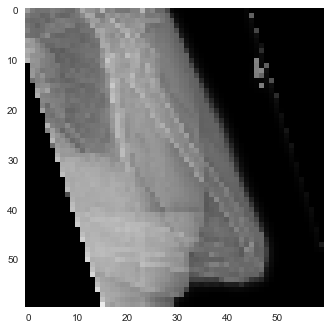

Predicted: Abnormal  [0.6887014]


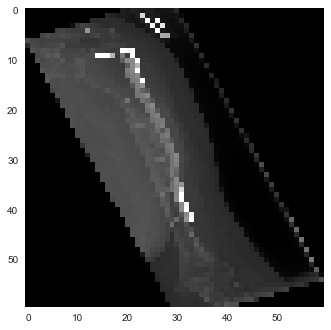

predicted: Normal [0.94070506]


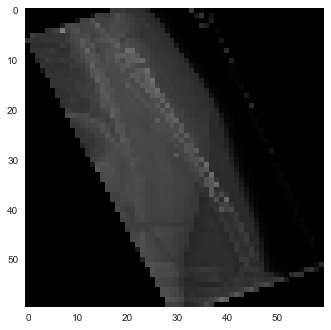

Predicted: Abnormal  [0.561446]


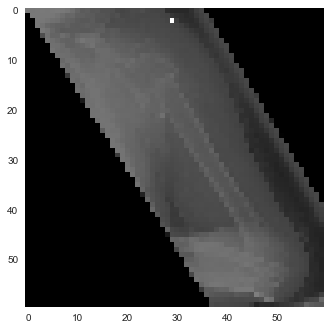

Predicted: Abnormal  [0.2569842]


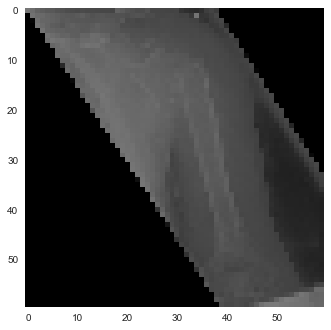

Predicted: Abnormal  [0.34513178]


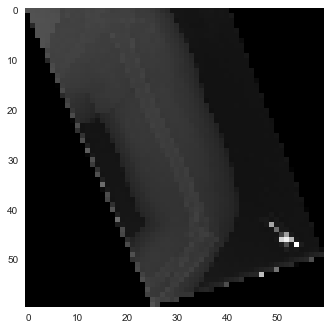

Predicted: Abnormal  [0.4994616]


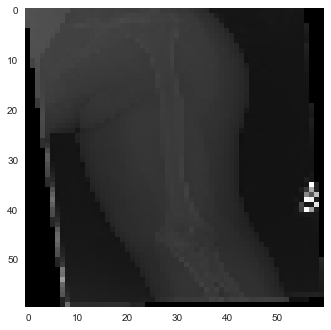

Predicted: Abnormal  [0.38567334]


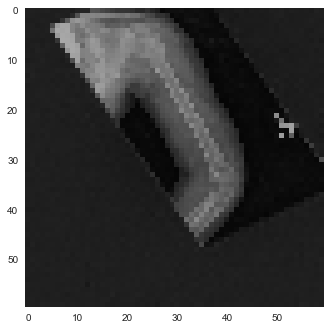

Predicted: Abnormal  [0.33856258]


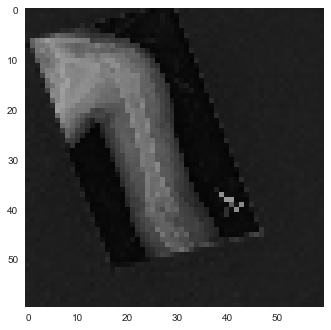

Predicted: Abnormal  [0.22717789]


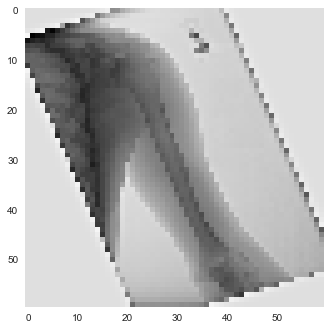

Predicted: Abnormal  [0.14608657]


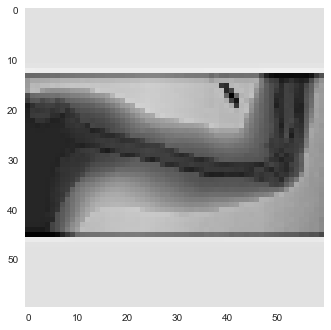

Predicted: Abnormal  [0.24937803]


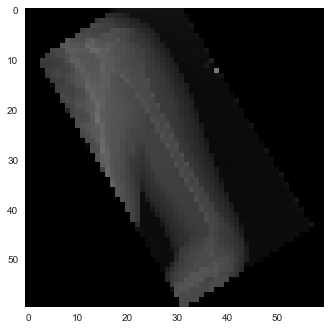

Predicted: Abnormal  [0.5164518]


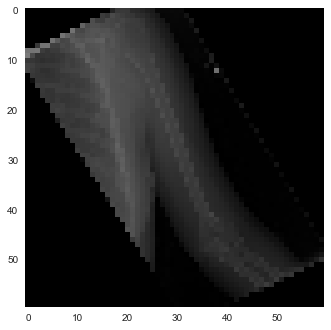

Predicted: Abnormal  [0.20863473]


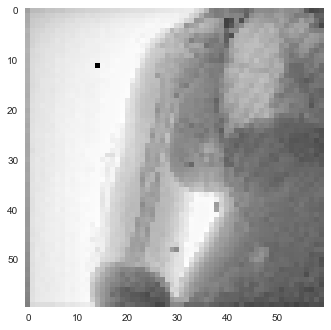

Predicted: Abnormal  [0.2430928]


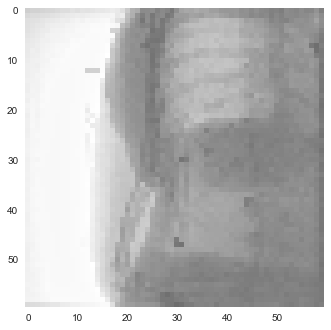

Predicted: Abnormal  [0.59339315]


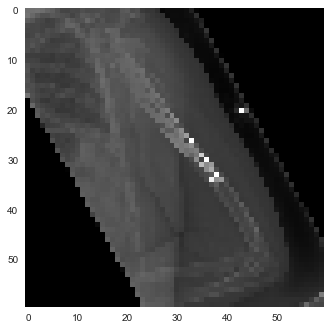

Predicted: Abnormal  [0.61142313]


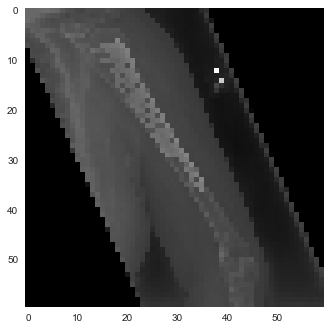

predicted: Normal [0.72176576]


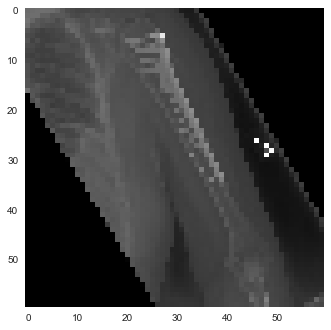

Predicted: Abnormal  [0.27775288]


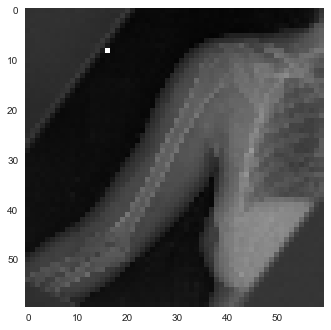

Predicted: Abnormal  [0.40332782]


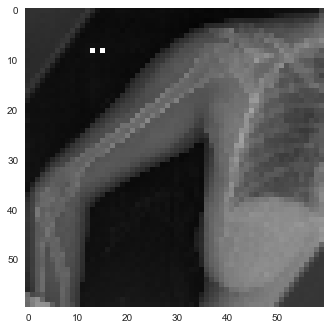

Predicted: Abnormal  [0.5919529]


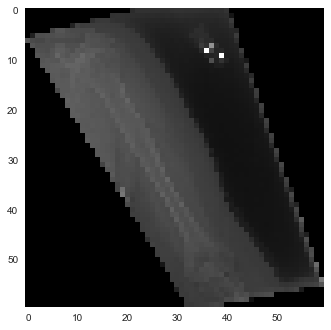

Predicted: Abnormal  [0.44421756]


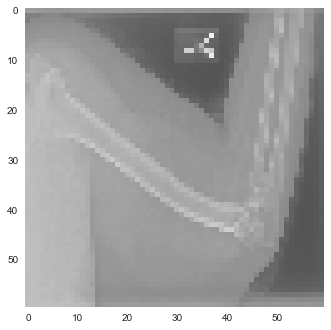

Predicted: Abnormal  [0.44665545]


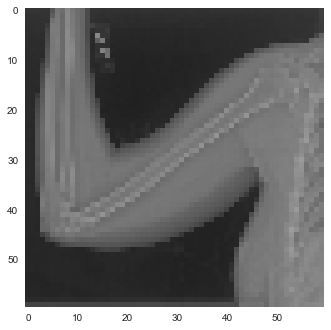

Predicted: Abnormal  [0.5255787]


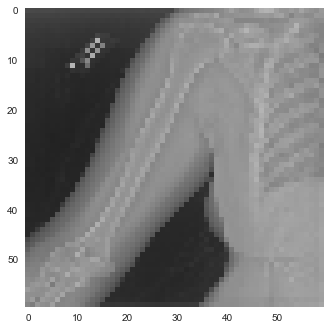

Predicted: Abnormal  [0.47075433]


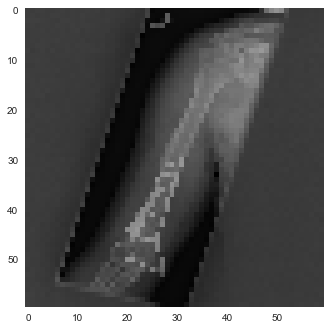

Predicted: Abnormal  [0.39560327]


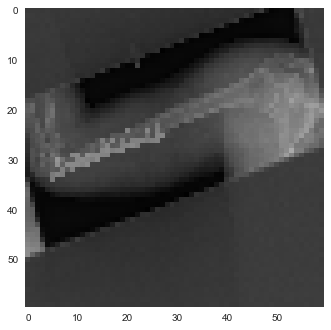

Predicted: Abnormal  [0.23794019]


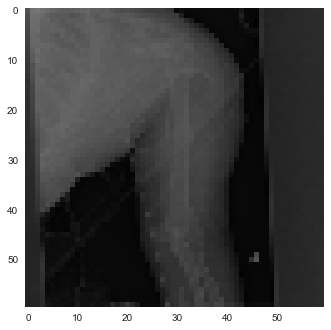

Predicted: Abnormal  [0.41077986]


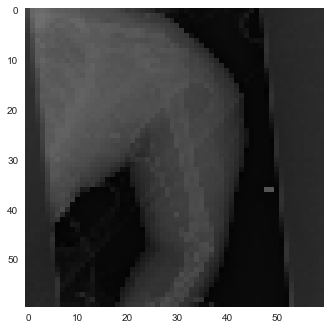

Predicted: Abnormal  [0.23308134]


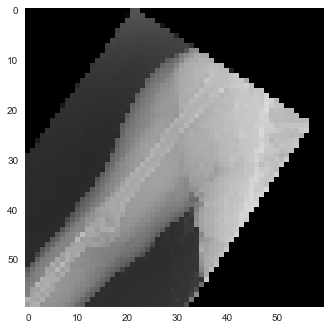

Predicted: Abnormal  [0.48813012]


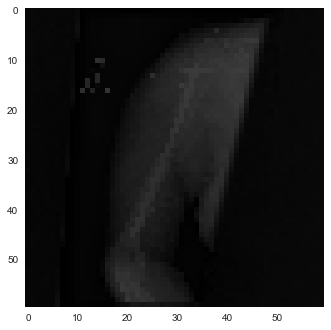

Predicted: Abnormal  [0.5096527]


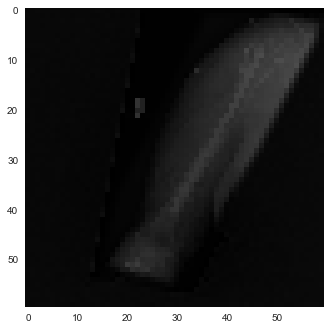

Predicted: Abnormal  [0.49400312]


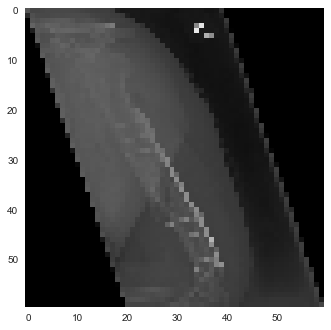

Predicted: Abnormal  [0.59158343]


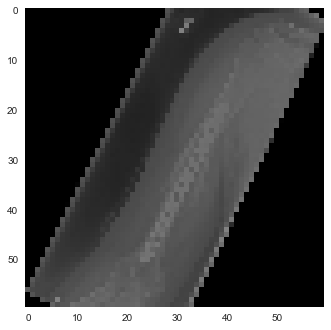

Predicted: Abnormal  [0.37657502]


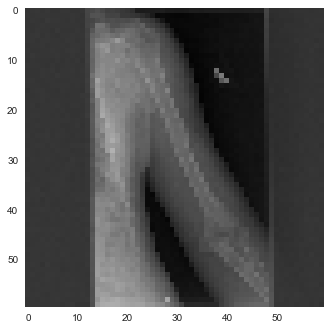

Predicted: Abnormal  [0.50823724]


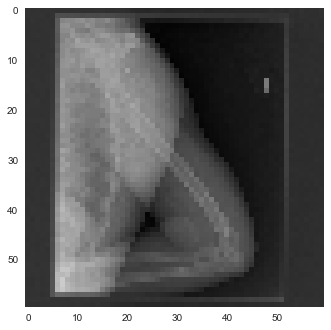

Predicted: Abnormal  [0.2479942]


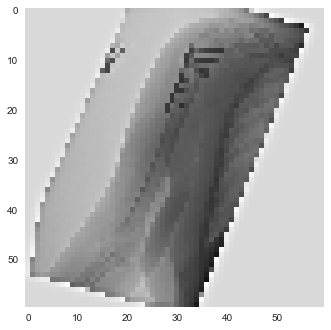

In [170]:
humerusClass='HUMERUS'
dataHumerus__Train_,labelsHumrus_Train,dataHumerus__Test,labelsHumerus_Test=prepareDataVGG(humerusClass)
historyHumerus,modelHumerus=vgg19Model(dataHumerus__Train_,labelsHumrus_Train,dataHumerus__Test,labelsHumerus_Test)
plotingModel(historyHumerus)
test_accHmerus=plotResults(dataHumerus__Test,labelsHumerus_Test,modelHumerus)

100%|██████████| 1754/1754 [00:32<00:00, 54.18it/s]


Train on 4931 samples, validate on 465 samples
Epoch 1/10
4931/4931 [==============================] - 1145s 232ms/step - loss: 5.2072 - accuracy: 0.5492 - val_loss: 3.6018 - val_accuracy: 0.6430
Epoch 2/10
4931/4931 [==============================] - 911s 185ms/step - loss: 3.3506 - accuracy: 0.6027 - val_loss: 2.8560 - val_accuracy: 0.6774
Epoch 3/10
4931/4931 [==============================] - 887s 180ms/step - loss: 2.5974 - accuracy: 0.6254 - val_loss: 2.2878 - val_accuracy: 0.6473
Epoch 4/10
4931/4931 [==============================] - 909s 184ms/step - loss: 2.0775 - accuracy: 0.6528 - val_loss: 1.8387 - val_accuracy: 0.7118
Epoch 5/10
4931/4931 [==============================] - 880s 179ms/step - loss: 1.6971 - accuracy: 0.6593 - val_loss: 1.5157 - val_accuracy: 0.7161
Epoch 6/10
4931/4931 [==============================] - 1188s 241ms/step - loss: 1.4252 - accuracy: 0.6656 - val_loss: 1.3072 - val_accuracy: 0.6903
Epoch 7/10
4931/4931 [==============================] - 1213s 2

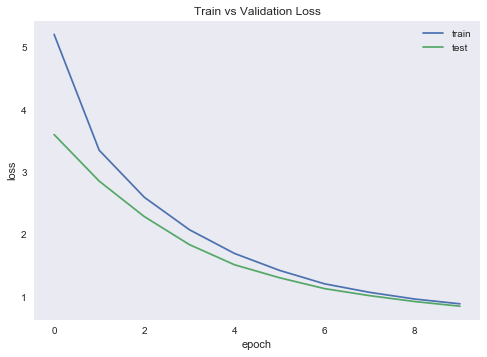

<Figure size 576x396 with 0 Axes>

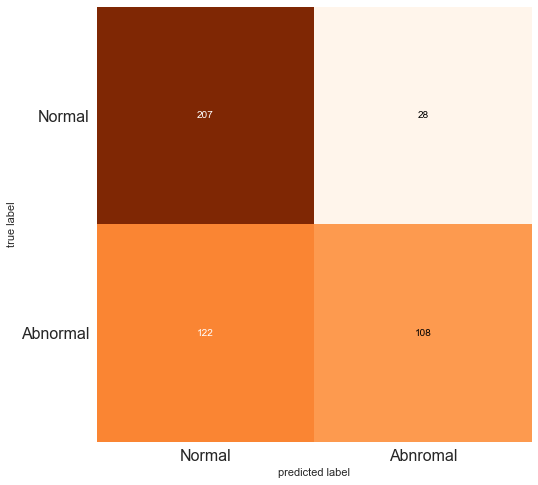

Precison of MURA for Abnormal:0.79
Recall of MURA for Abnormal:0.47
Predicted: Abnormal  [0.3903708]


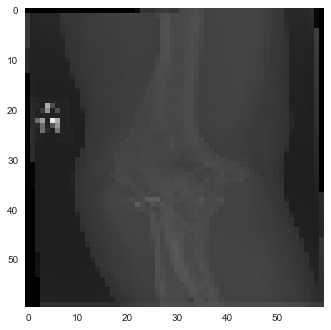

predicted: Normal [0.7380741]


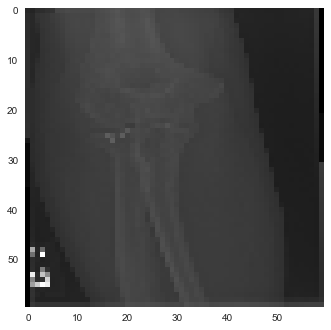

Predicted: Abnormal  [0.49700576]


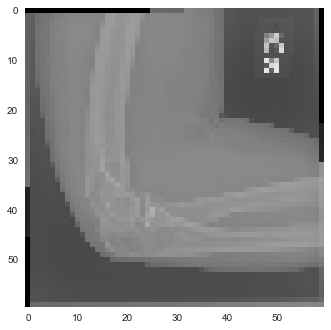

Predicted: Abnormal  [0.45944646]


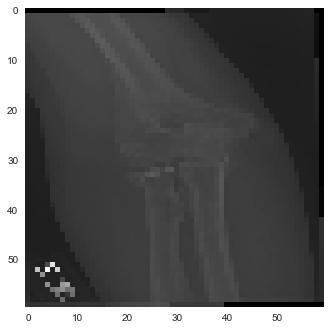

predicted: Normal [0.70549583]


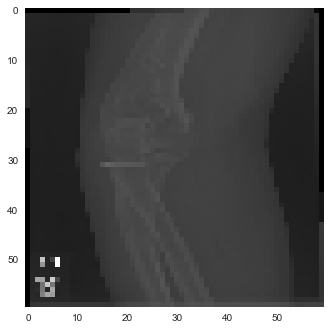

Predicted: Abnormal  [0.6418131]


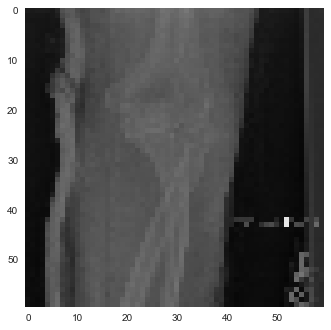

Predicted: Abnormal  [0.44356865]


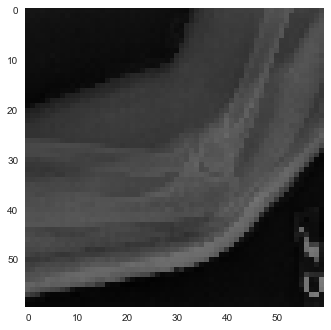

Predicted: Abnormal  [0.4221694]


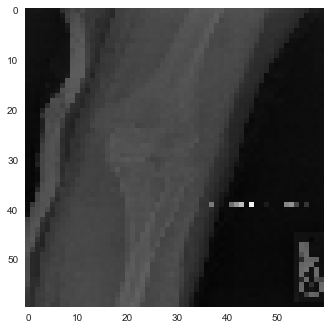

Predicted: Abnormal  [0.42506367]


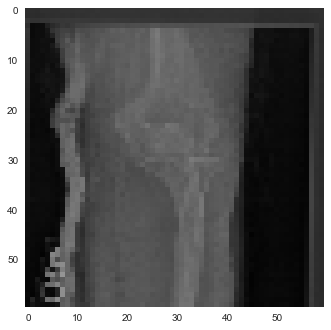

Predicted: Abnormal  [0.33901066]


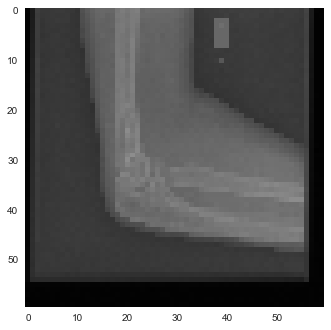

Predicted: Abnormal  [0.37887126]


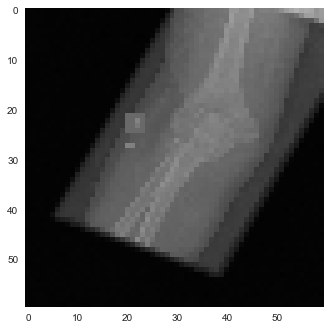

Predicted: Abnormal  [0.03232563]


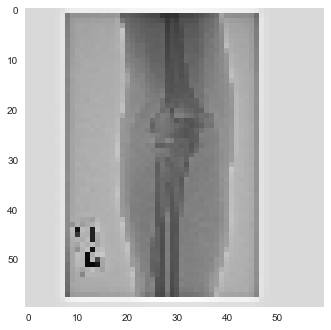

Predicted: Abnormal  [0.41704348]


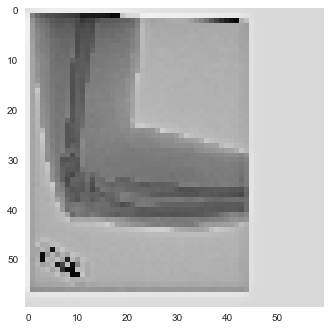

Predicted: Abnormal  [0.47810993]


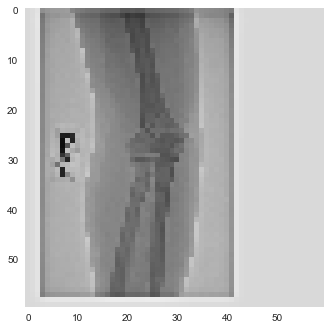

Predicted: Abnormal  [0.46213877]


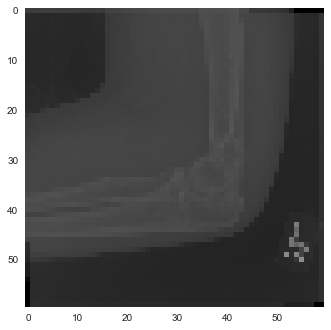

predicted: Normal [0.7397064]


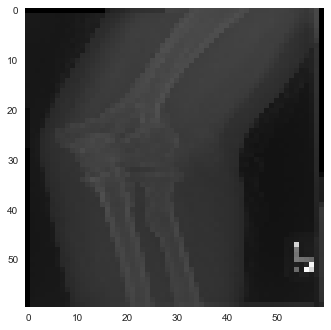

Predicted: Abnormal  [0.6676628]


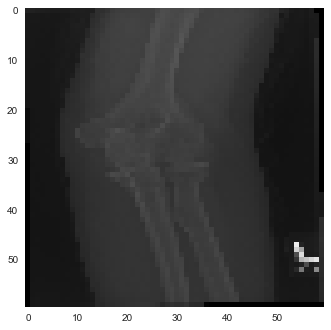

Predicted: Abnormal  [0.2588629]


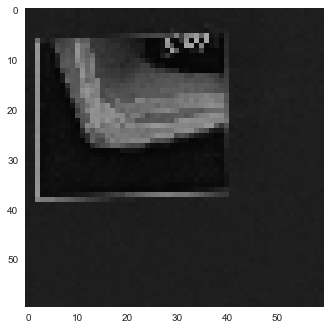

Predicted: Abnormal  [0.22150755]


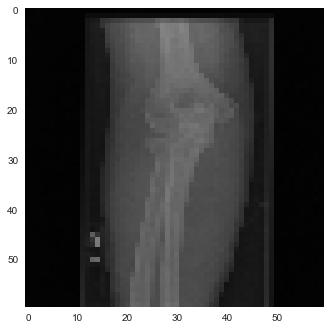

Predicted: Abnormal  [0.29928067]


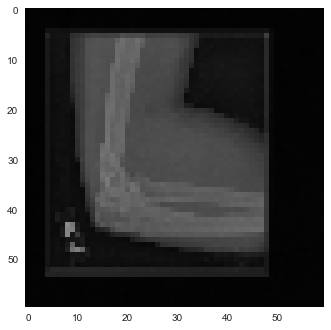

Predicted: Abnormal  [0.39660186]


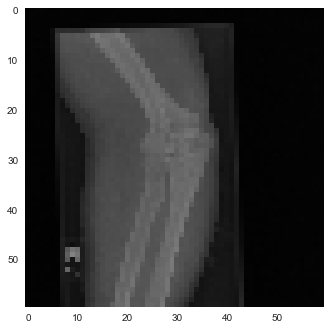

Predicted: Abnormal  [0.58303803]


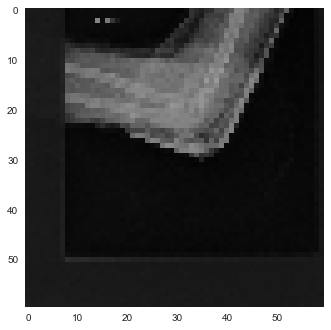

Predicted: Abnormal  [0.53053063]


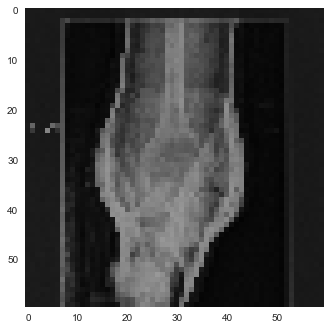

Predicted: Abnormal  [0.3050307]


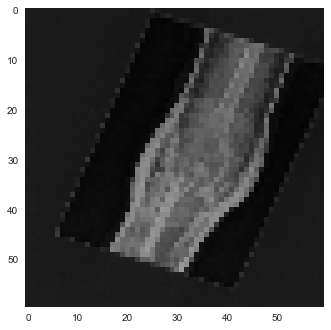

Predicted: Abnormal  [0.3126713]


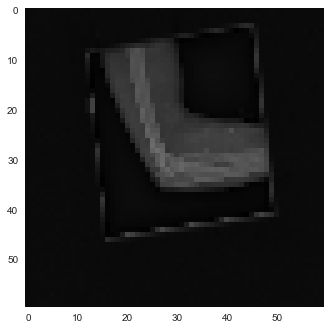

Predicted: Abnormal  [0.26804537]


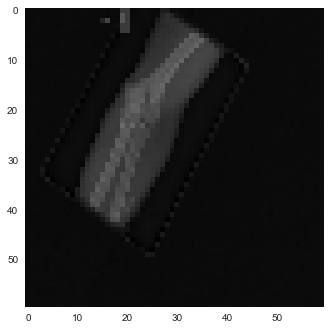

Predicted: Abnormal  [0.32999158]


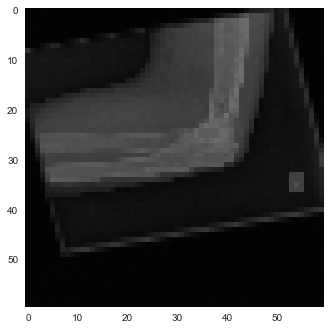

Predicted: Abnormal  [0.32406896]


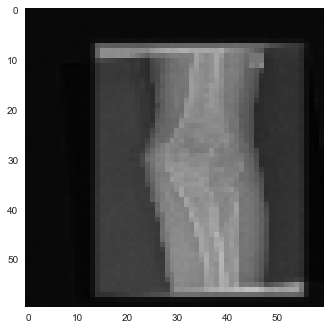

Predicted: Abnormal  [0.28004038]


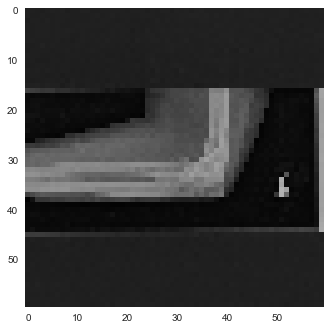

Predicted: Abnormal  [0.32175004]


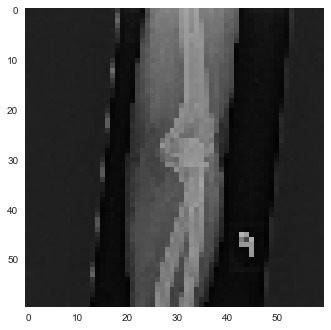

Predicted: Abnormal  [0.4452513]


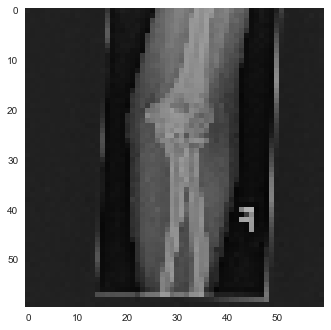

Predicted: Abnormal  [0.44179544]


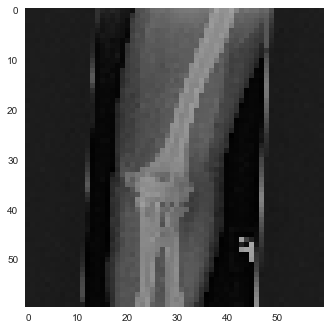

Predicted: Abnormal  [0.38789824]


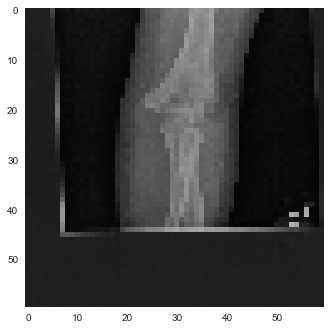

Predicted: Abnormal  [0.3420118]


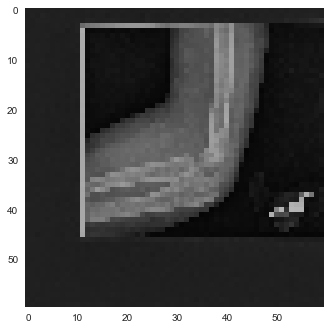

Predicted: Abnormal  [0.36156732]


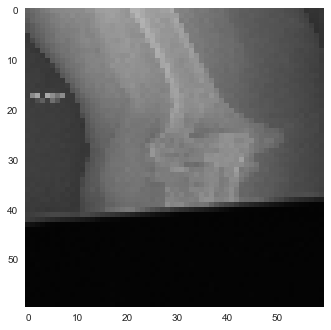

Predicted: Abnormal  [0.3183527]


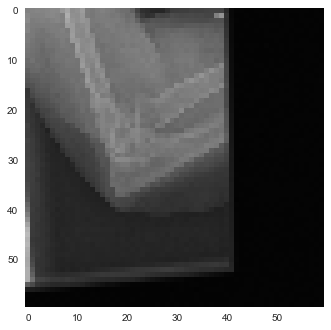

Predicted: Abnormal  [0.50517064]


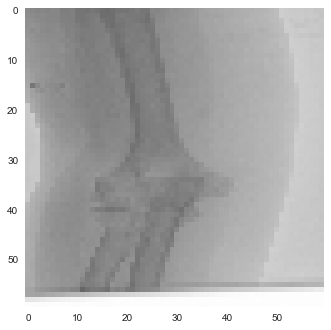

Predicted: Abnormal  [0.26309776]


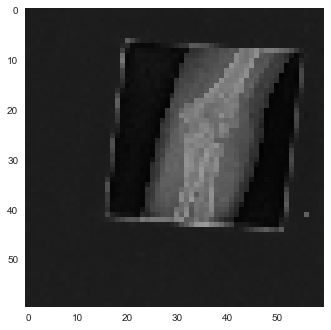

Predicted: Abnormal  [0.34916276]


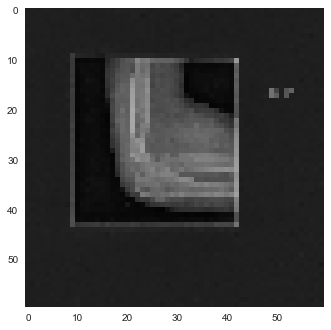

Predicted: Abnormal  [0.2605092]


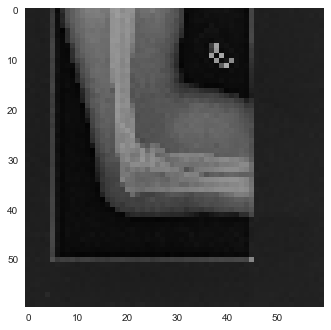

Predicted: Abnormal  [0.17985329]


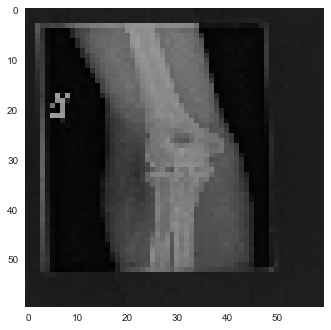

Predicted: Abnormal  [0.19052464]


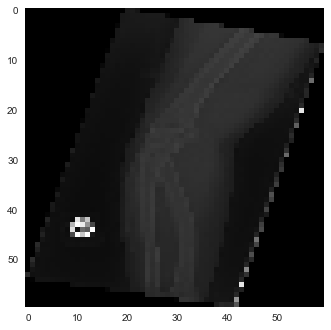

Predicted: Abnormal  [0.37082455]


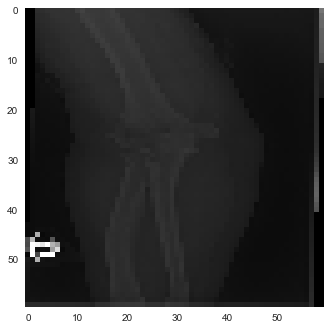

Predicted: Abnormal  [0.34629574]


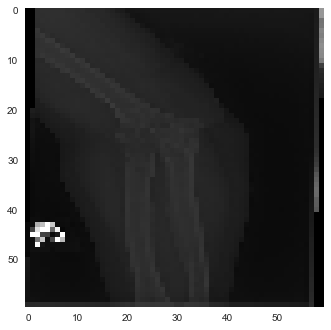

Predicted: Abnormal  [0.35815644]


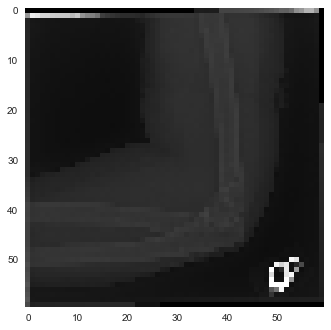

Predicted: Abnormal  [0.35265005]


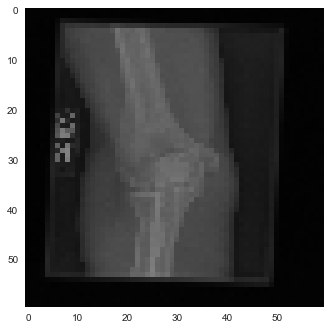

Predicted: Abnormal  [0.37804127]


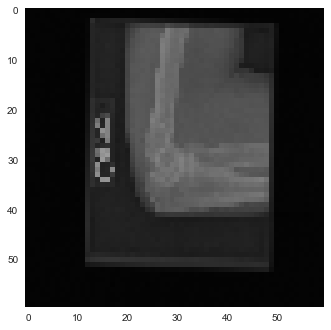

Predicted: Abnormal  [0.31394953]


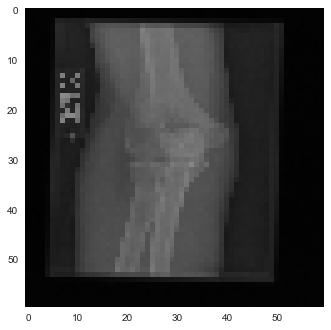

Predicted: Abnormal  [0.5368172]


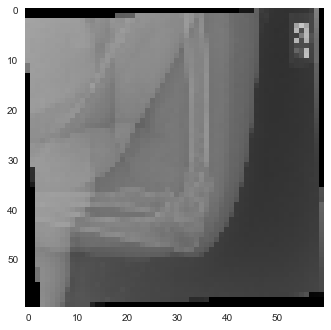

Predicted: Abnormal  [0.5630686]


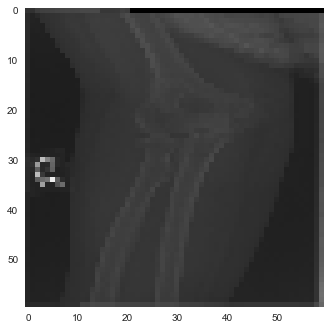

In [171]:
elbowClass='ELBOW'
dataElbow__Train_,labelsElbow_Train,dataElbow__Test,labelsWlbow_Test=prepareDataVGG(elbowClass)
historyElbow,modelElbow=vgg19Model(dataElbow__Train_,labelsElbow_Train,dataElbow__Test,labelsWlbow_Test)
plotingModel(historyElbow)
test_accElbow=plotResults(dataElbow__Test,labelsWlbow_Test,modelElbow)

In [ ]:
fingerClass='FINGER'
dataFinger__Train_,labelsFinger_Train,dataFinger__Test,labelsFinger_Test=prepareDataVGG(fingerClass)
historyFinger,modelFinger=vgg19Model(dataFinger__Train_,labelsFinger_Train,dataFinger__Test,labelsFinger_Test)
plotingModel(historyFinger)
test_accFinger=plotResults(dataFinger__Test,labelsFinger_Test,modelFinger)

100%|██████████| 1935/1935 [00:38<00:00, 50.79it/s]


Train on 5106 samples, validate on 461 samples
Epoch 1/10
1728/5106 [=========>....................] - ETA: 15:02 - loss: 5.6302 - accuracy: 0.5932

In [ ]:
armClass='FOREARM'
dataArm__Train_,labelsArm_Train,dataArm__Test,labelsArm_Test=prepareDataVGG(armClass)
historyArm,modelArm=vgg19Model(dataArm__Train_,labelsArm_Train,dataArm__Test,labelsArm_Test)
plotingModel(historyArm)
test_accArm=plotResults(dataArm__Test,labelsArm_Test,modelArm)

In [ ]:
handClass='HAND'
dataHand__Train_,labelsHand_Train,dataHand__Test,labelsHand_Test=prepareDataVGG(handClass)
historyHand,modelHand=vgg19Model(dataHand__Train_,labelsHand_Train,dataHand__Test,labelsHand_Test)
plotingModel(historyHand)
test_accHand=plotResults(dataHand__Test,labelsHand_Test,modelHand)

In [ ]:
shoulderClass='SHOULDER'
dataShoulder__Train_,labelsShoulder_Train,dataShoulder__Test,labelsShoulder_Test=prepareDataVGG(shoulderClass)
historyShoulder,modelShoulder=vgg19Model(dataShoulder__Train_,labelsShoulder_Train,dataShoulder__Test,labelsShoulder_Test)
plotingModel(historyShoulder)
test_accShoulder=plotResults(dataShoulder__Test,labelsShoulder_Test,modelShoulder)

In [ ]:
wristClass='WRIST'
dataWrist__Train_,labelsWrist_Train,dataWrist__Test,labelsWrist_Test=prepareDataVGG(wristClass)
historyWrist,modelWrist=vgg19Model(dataWrist__Train_,labelsWrist_Train,dataWrist__Test,labelsWrist_Test)
plotingModel(historyWrist)
test_accWrist=plotResults(dataWrist__Test,labelsWrist_Test,modelWrist)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bodyPart = ['ELBOW', 'FINGER','FOREARM','HAND', 'HUMERUS', 'SHOULDER', 'WRIST']
test_acc = [test_accElbow,test_accFinger,test_accArm,test_accHand,test_accHmerus,test_accShoulder,test_accWrist]
ax.bar(bodyPart,test_acc)
plt.show()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.mobilenet import MobileNet
from keras.optimizers import Adam

In [ ]:
from keras import regularizers

def mobileNet_Model(data__Train,labels_Train,data__Test,labels_Test):

    base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(64,activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(x) 
    x = Dropout(0.5)(x)
    preds=Dense(1, activation='softmax')(x)
    model=Model(inputs=base_model.input,outputs=preds)
    for layer in model.layers[:64]:
        layer.trainable=False
    for layer in model.layers[64:]:
        layer.trainable=True
    model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(data__Train, labels_Train, epochs=10, batch_size=32, workers=10, validation_data=(data__Test, labels_Test))
    return history, model

In [ ]:
elbowClass='ELBOW'
dataElbow__Train_mobile,labelsElbow_Train_mobile,dataElbow__Test_mobile,labelsWlbow_Test_mobile=prepareDataMobile(elbowClass)

In [ ]:
historyMobile, modelMobile=mobileNet_Model(dataElbow__Train_mobile,labelsElbow_Train_mobile,dataElbow__Test_mobile,labelsWlbow_Test_mobile)

In [ ]:
plotingModel(historyMobile)
test_accShoulder=plotResults(dataElbow__Test_mobile,labelsWlbow_Test_mobile,modelMobile)